In [1]:
import numpy as np
from modem_cls import PSKModem
from filter_cls import GaussFilter
from configuration import*
import matplotlib.pyplot as plt
%matplotlib widget

### Task 1

In [2]:
# configuration and message generation
np.random.seed(1)
config = config_multiplicity
bit_message = np.random.randint(low=0, high=2, size=config['num_transmit_bits'])
modem_block = PSKModem(config_multiplicity['modulation'])

In [3]:
# processing block
symbols = modem_block.map_symbols(bit_message)
signal = modem_block.modulate(bit_message, config['f_sample_rate_Hz'], config['f_carrier_Hz'], config['f_symbol_rate'])
time_array = np.arange(0, len(signal), 1) / config['f_sample_rate_Hz']
rec_bits = modem_block.demodulate(signal, config['f_sample_rate_Hz'], config['f_carrier_Hz'], config['f_symbol_rate'])
print('Bit message: ', bit_message)
print('Modulation symbols: ', symbols)
print('Demodulated bits: ', rec_bits)

Bit message:  [1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0]
Modulation symbols:  [-1.00000000e+00+1.22464680e-16j  6.12323400e-17+1.00000000e+00j
 -7.07106781e-01-7.07106781e-01j  7.07106781e-01+7.07106781e-01j
  6.12323400e-17+1.00000000e+00j  7.07106781e-01+7.07106781e-01j
  1.00000000e+00+0.00000000e+00j  7.07106781e-01-7.07106781e-01j]
Demodulated bits:  [1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0]


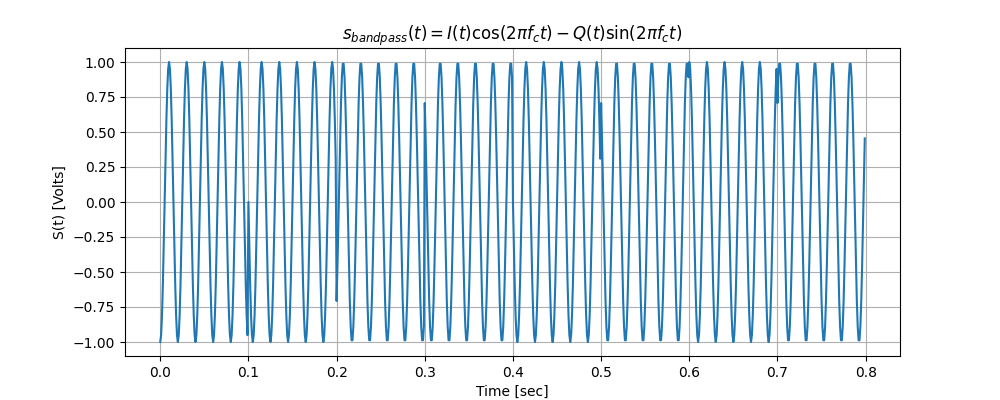

In [4]:
fig1 = plt.figure(figsize=[10,4])
ax_1 = fig1.add_subplot(111)

ax_1.set_title(r'$s_{bandpass}(t)=I(t)\cos(2\pi f_c t)-Q(t)\sin(2\pi f_c t)$')
ax_1.plot(time_array,signal)
ax_1.set_xlabel('Time [sec]')
ax_1.set_ylabel('S(t) [Volts]')
ax_1.grid()

### Task 2

In [5]:
shape_filter = GaussFilter(1/config['f_symbol_rate'], int(config['f_sample_rate_Hz']/config['f_symbol_rate']))
symbols_seq = modem_block.padded_symbols(bit_message, config['f_sample_rate_Hz'], config['f_symbol_rate'])
output_baseband_signal = np.convolve(symbols_seq, shape_filter.h_impulse_response, mode='full')

time_samples = np.arange(0, len(output_baseband_signal), 1)/config['f_sample_rate_Hz']-2/config['f_symbol_rate']

output_bandpass_signal = np.real(output_baseband_signal*np.exp(1j*2*np.pi*config['f_carrier_Hz']*time_samples))

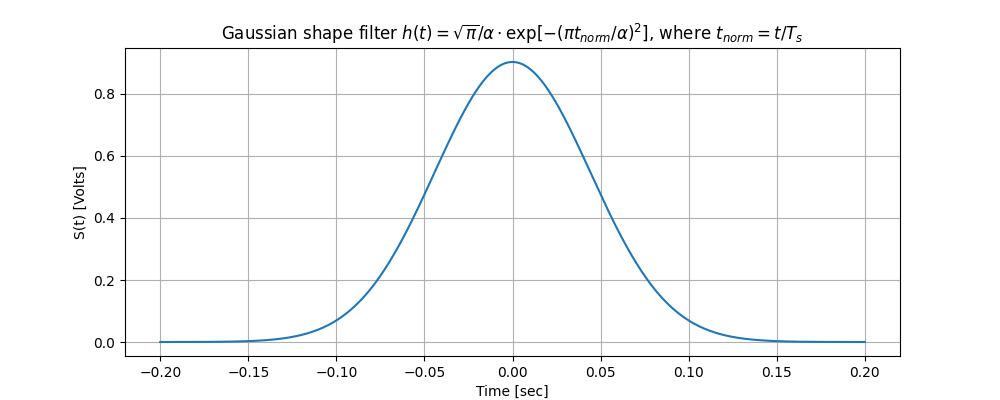

In [6]:
fig2 = plt.figure(figsize=[10,4])
ax_1 = fig2.add_subplot(111)

ax_1.set_title(r'Gaussian shape filter $h(t)=\sqrt{\pi}/\alpha\cdot\exp[-(\pi t_{norm}/\alpha)^2]$, where $t_{norm}=t/T_s$')
ax_1.plot(shape_filter.get_abs_time(config['f_symbol_rate']), shape_filter.h_impulse_response)
ax_1.set_xlabel('Time [sec]')
ax_1.set_ylabel('S(t) [Volts]')
ax_1.grid()

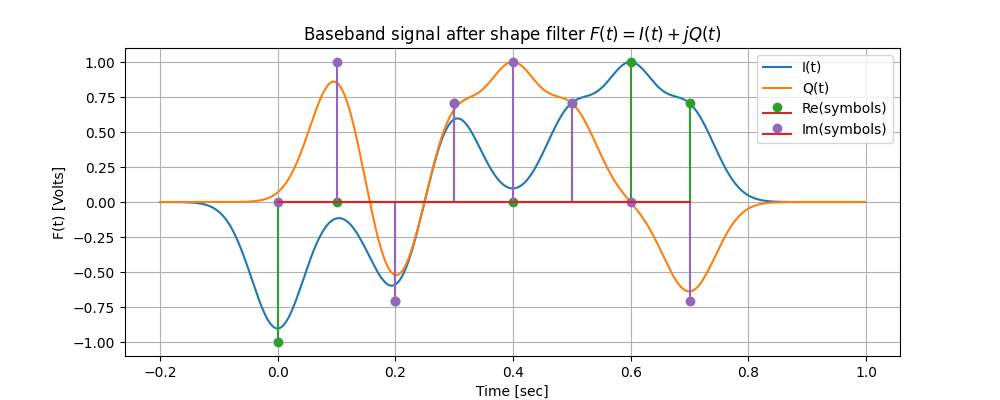

In [7]:
fig3 = plt.figure(figsize=[10,4])
ax_1 = fig3.add_subplot(111)

ax_1.set_title(r'Baseband signal after shape filter $F(t)=I(t)+jQ(t)$')
ax_1.plot(time_samples, np.real(output_baseband_signal), label='I(t)')
ax_1.plot(time_samples, np.imag(output_baseband_signal), label='Q(t)')
ax_1.stem(np.arange(0, len(bit_message)//modem_block.get_bits_per_symbol())/config['f_symbol_rate'], np.real(symbols), linefmt='C2-', markerfmt='C2o',label='Re(symbols)')
ax_1.stem(np.arange(0, len(bit_message)//modem_block.get_bits_per_symbol())/config['f_symbol_rate'], np.imag(symbols), linefmt='C4-', markerfmt='C4o',label='Im(symbols)')
ax_1.set_xlabel('Time [sec]')
ax_1.set_ylabel('F(t) [Volts]')
ax_1.legend()
ax_1.grid()

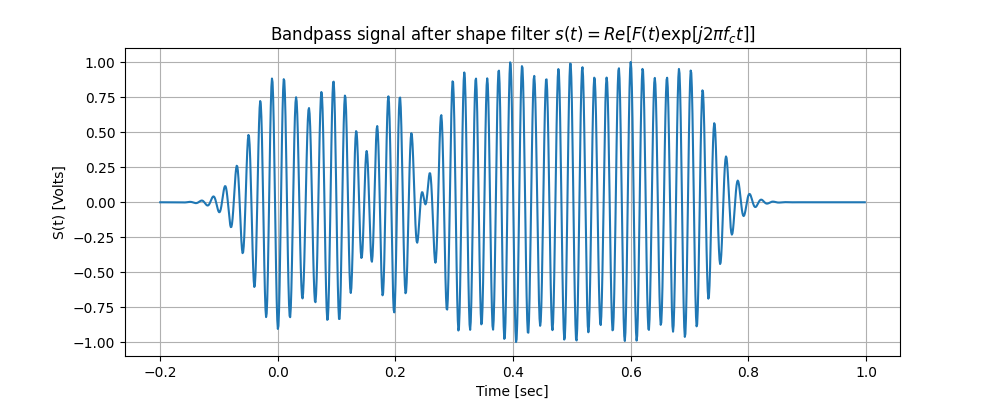

In [8]:
fig4 = plt.figure(figsize=[10,4])
ax_1 = fig4.add_subplot(111)

ax_1.set_title(r'Bandpass signal after shape filter $s(t)=Re[F(t)\exp[j2\pi f_ct]]$')
ax_1.plot(time_samples, output_bandpass_signal)
ax_1.set_xlabel('Time [sec]')
ax_1.set_ylabel('S(t) [Volts]')
ax_1.grid()

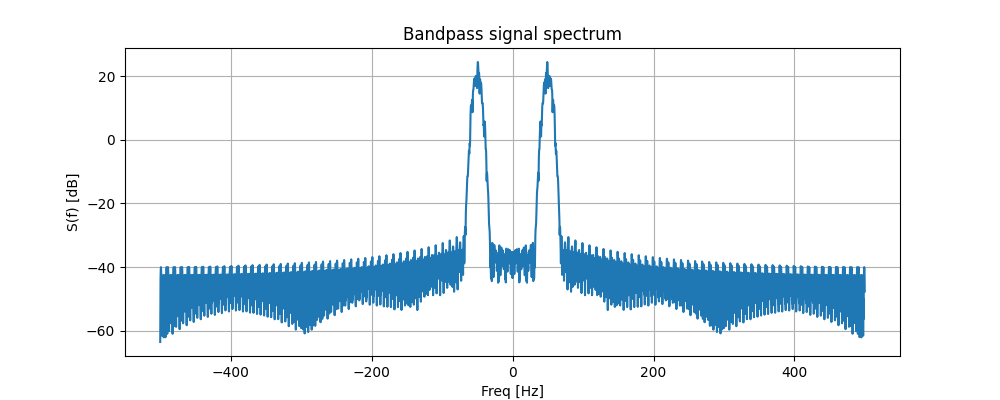

In [9]:
N_fft = len(time_samples) * 4

fig4_1 = plt.figure(figsize=[10,4])
ax_1 = fig4_1.add_subplot(111)

ax_1.set_title(r'Bandpass signal spectrum')
ax_1.plot(1/(time_samples[1]-time_samples[0])/N_fft*np.arange(-N_fft/2,N_fft/2,1), 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(output_bandpass_signal, N_fft)))))
ax_1.set_xlabel('Freq [Hz]')
ax_1.set_ylabel('S(f) [dB]')
ax_1.grid()

### Task 3

In [10]:
data_bpsk = np.load('data_bpsk.npy')
data_qpsk = np.load('data_qpsk.npy')
data_scramb = np.load('scramb.npy')

In [11]:
bpsk_reduced = np.array(list([data_bpsk[i] for i in range(24, len(data_bpsk), 4)]))
bpsk_reduced = bpsk_reduced[:100]
qpsk_reduced = np.array(list([data_qpsk[i] for i in range(24, len(data_bpsk), 4)]))
qpsk_reduced = qpsk_reduced[:100]

In [12]:
descr_seq = np.exp(-1j*2*np.pi/8*data_scramb)
descr_bpsk = bpsk_reduced*descr_seq
descr_qpsk = qpsk_reduced*descr_seq

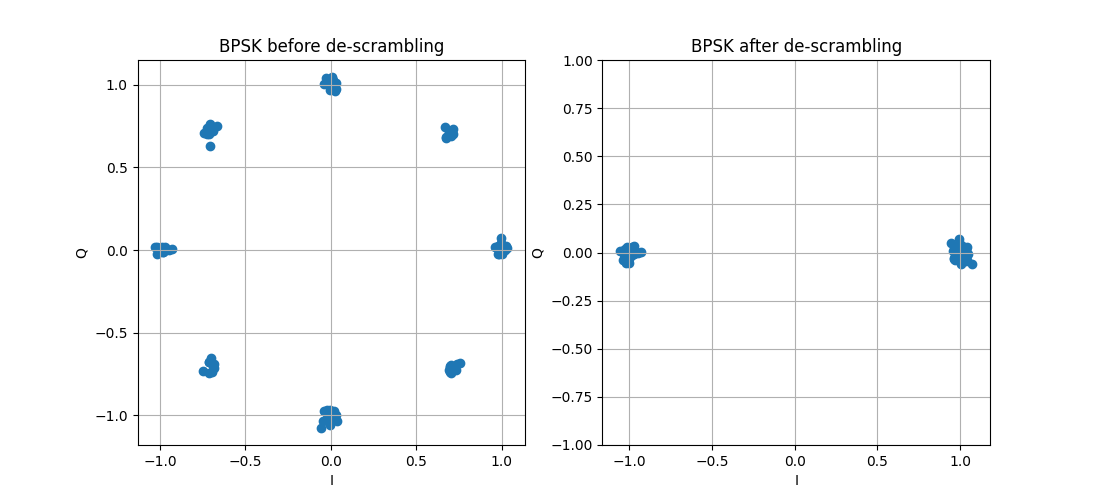

In [13]:
fig5 = plt.figure(figsize=[11,5])

ax_1 = fig5.add_subplot(121)
ax_1.set_title(r'BPSK before de-scrambling')
ax_1.scatter(np.real(bpsk_reduced), np.imag(bpsk_reduced))
ax_1.set_xlabel('I')
ax_1.set_ylabel('Q')
ax_1.grid()

ax_2 = fig5.add_subplot(122)
ax_2.set_title(r'BPSK after de-scrambling')
ax_2.scatter(np.real(descr_bpsk), np.imag(descr_bpsk))
ax_2.set_xlabel('I')
ax_2.set_ylabel('Q')
ax_2.set_ylim([-1,1])
ax_2.grid()

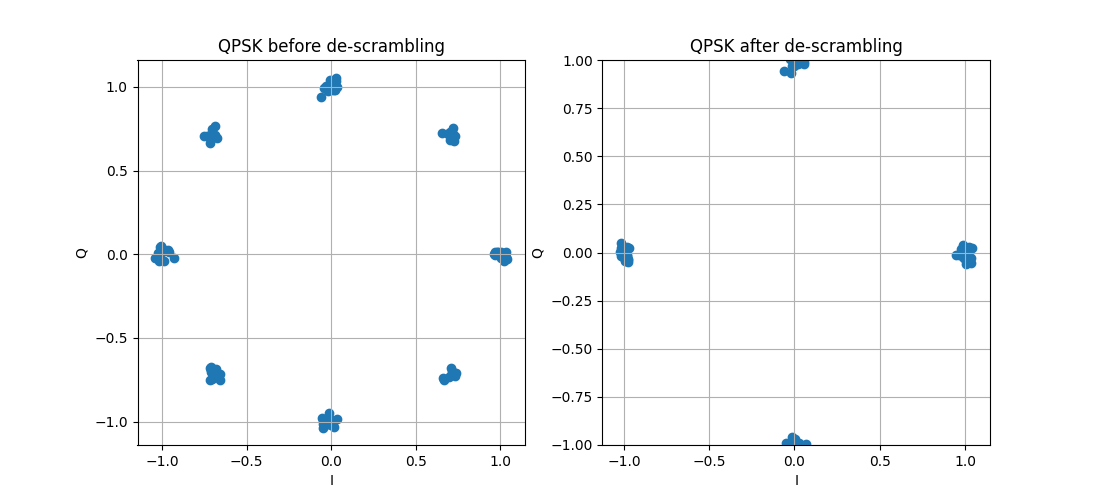

In [14]:
fig6 = plt.figure(figsize=[11,5])

ax_1 = fig6.add_subplot(121)
ax_1.set_title(r'QPSK before de-scrambling')
ax_1.scatter(np.real(qpsk_reduced), np.imag(qpsk_reduced))
ax_1.set_xlabel('I')
ax_1.set_ylabel('Q')
ax_1.grid()

ax_2 = fig6.add_subplot(122)
ax_2.set_title(r'QPSK after de-scrambling')
ax_2.scatter(np.real(descr_qpsk), np.imag(descr_qpsk))
ax_2.set_xlabel('I')
ax_2.set_ylabel('Q')
ax_2.set_ylim([-1,1])
ax_2.grid()

In [15]:
bpsk_message = modem_block.demap_symbols(descr_bpsk)
qpsk_message = modem_block.demap_symbols(descr_qpsk)
print('BPSK bits:',*bpsk_message)
print('QPSK bits:',*qpsk_message)

BPSK bits: 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0
QPSK bits: 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 